# Kerbal Space Program kOS Hover PID planner
*Author: Sam Ansari*

So we're going to try and write a [kOS](http://ksp-kos.github.io/KOS_DOC/) script for Kerbal Space Program (KSP) to control a single-stage rocket engine to hover at a set altitude. Our intrepid little spaceship consists of a single engine, some landing legs and a parachute in case (when) our controller goes haywire.

![The Interpid](images/ship_closeup.png)

As our first step for hovering, we'll have our controller change in velocity by limiting our g_force to 0 via $gforce_{goal}=1.0$.

$$
\begin{align}
    gforce &= \|\mathbf{a}\| / g \Longrightarrow gforce_{measured} =  \|\mathbf{a_{measured}}\| / g_{measured} \\
    \Delta thrott &= Kp(gforce_{goal} - gforce_{measured}) = Kp(1.0 - gforce_{measured}) \\
    thrott &= thrott + \Delta thrott
\end{align}
$$

Where $\|\mathbf{a_{measured}}\|$ is our measured current max acceleration using an onboard accelerometer and $g_{measured}$ is our onboard gravitational acceleration magnitude using our graviola detector.

And in the running controller loop, we update $thrott = thrott + \Delta thrott$

    SET thrott to thrott + dthrott.

Where thrott is the throttle percentage from 0 to 1 or no thrust to full thrust. This has the effect of trying to move gforce to 1.0, matching the gravitational force.


## Setup & Helper functions
First let's set up some helper functions for loading data and plotting.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from matplotlib.font_manager import FontProperties
from pylab import rcParams
fontP = FontProperties()
fontP.set_size('small')

def loadData(filename):
    return genfromtxt(filename, delimiter=' ')

def plotData(data):
    rcParams['figure.figsize'] = 10, 6 # Set figure size to 10" wide x 6" tall
    t = data[:,0]
    altitude = data[:,1]
    verticalspeed = data[:,2]
    acceleration = data[:,3] # magnitude of acceleration
    gforce = data[:,4]
    throttle = data[:,5] * 100
    dthrottle_p = data[:,6] * 100
    dthrottle_d = data[:,7] * 100
    
    
    # Top subplot, position and velocity up to threshold
    plt.subplot(3, 1, 1)
    plt.plot(t, altitude, t, verticalspeed, t, acceleration)
    plt.axhline(y=100,linewidth=1,alpha=0.5,color='r',linestyle='--',label='goal');
    plt.text(max(t)*0.9, 105, 'Goal Altitude', fontsize=8);
    plt.title('Craft Altitude over Time')
    plt.ylabel('Altitude (meters)')
    plt.legend(['Altitude (m)','Vertical Speed (m/s)', 'Acceleration (m/s^2)'], "best", prop=fontP, frameon=False)
    
    # Middle subplot, throttle & dthrottle
    plt.subplot(3, 1, 2)
    plt.plot(t, throttle, t, dthrottle_p, t, dthrottle_d)
    plt.legend(['Throttle%','P','D'], "best",  prop=fontP, frameon=False) # Small font, best location
    plt.ylabel('Throttle %')
                
    # Bottom subplot, gforce
    plt.subplot(3, 1, 3)
    plt.plot(t, gforce)
    plt.axhline(y=1,linewidth=1,alpha=0.5,color='r',linestyle='--',label='goal');
    plt.text(max(t)*0.9, 1.2, 'Goal g-force', fontsize=8);
    plt.legend(['gforce'], "best", bbox_to_anchor=(1.0, 1.0), prop=fontP, frameon = False) # Small font, best location
    plt.xlabel('Time (seconds)')
    plt.ylabel('G-force');
    plt.show();

# G-force Control

As a first test, we'll start from the launchpad, thrust at full throttle till we hit $altitude_{goal} > 100\ \text{meters}$ and then use a proportional gain of $Kp = 0.05$ to keep $gforce \sim 1.0$.

    LOCK dthrott_p TO Kp * (1.0 - gforce).
    LOCK dthrott TO dthrott_p.

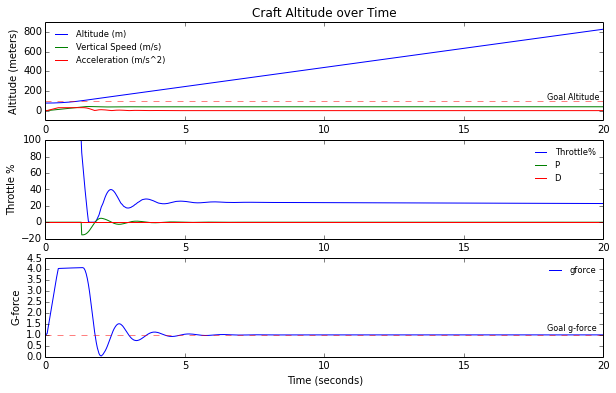

In [2]:
data = loadData('collected_data\\gforce.txt')
plotData(data)

Pretty cool! Once it passes 100m altitude the controller starts, the throttle controls for gforce, bringing it oscillating down around 1g. This zeros our acceleration but not our existing velocity, so the position continues to increase. We could add some derivative gain to damp down the gforce overshoot, but it won't solve this problem yet.

The kOS script to run this test is located in `hover1.ks` and called by `RUN hover1(gforce.txt,20).`

# Vertical Speed Control
Let's try to get our vertical speed to zero now, causing our position to stay in one spot: $verticalspeed_{goal} = 0$

Instead of using $\Delta thrott = Kp * (1.0 - gforce)$ we'll control for vertical speed with 

$$\Delta thrott = Kp(verticalspeed_{goal} - verticalspeed_{measured}) = Kp(-verticalspeed_{measured})$$

    LOCK dthrott_p TO Kp * (0 - SHIP:VERTICALSPEED).
    LOCK dthrott TO dthrott_p.

And use the same proportional gain of $Kp = 0.05$.

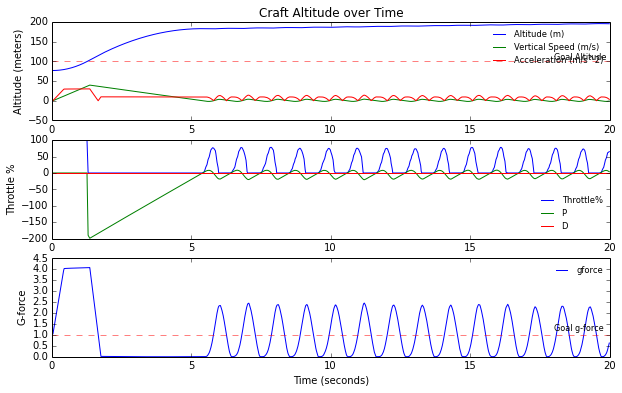

In [3]:
data = loadData('collected_data\\vspeed.txt')
plotData(data)

Awesome! The controller drops the velocity to a stable oscillation around 0 m/s, and the position seems to flatten off, but it isn't perfect. Maybe it's because of the oscillations? In the game I can see the engine spurt on and off rythmically. It seems to try and stay at roughly 0 m/s, but the position is not 100m and it drifts.

The kOS script to run this test is located in `hover2.ks` and called by `RUN hover2(vspeed.txt,20).`

# Position Control
Instead of gforce or velocity, lets try controlling for position next.

$$ \Delta thrott = K_p(altitude_{goal} - altitude_{current}) $$

Using $Kp = 0.05$ and  $altitude_{goal} = 100$. 

    LOCK dthrott_p TO Kp * (goal_altitude - SHIP:ALTITUDE).
    LOCK dthrott TO dthrott_p.

**Note:** *From now on we start the controller directly from the launch pad (instead of burning till passing 100m).*

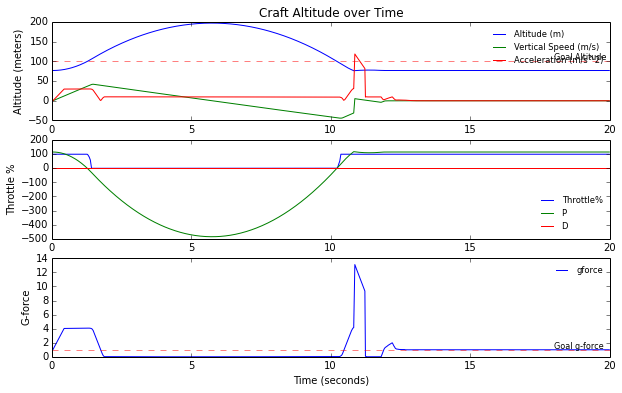

In [4]:
# To run in kOS console: RUN hover3(pos0.txt,20,0.05,0).
data = loadData('collected_data\\pos0.txt')
plotData(data)

Well, we crashed.

Turns out an ideal stable oscillation (which Proportional only controllers tend to do) starting from ground level (around 76m from where the accelerometer is located on the landed craft) would necessarily come back to that point...

Lets try adding some derivative gain to damp that out, the derivative of altitude is just the vertical speed.

$$
\Delta thrott = K_p(altitude_{goal} - altitude_{current}) + K_d(verticalspeed_{goal} - verticalspeed_{current}) \\
thrott = thrott + \Delta thrott
$$

    LOCK dthrott_p TO Kp * (goal_altitude - SHIP:ALTITUDE).
    LOCK dthrott_d TO Kd * (0 - SHIP:VERTICALSPEED).
    LOCK dthrott TO dthrott_p + dthrott_d.

Using $Kp = 0.05,\ \ Kd = 0.05$, $altitude_{goal} = 100\ \text{meters}$ and $verticalspeed_{goal} = 0$

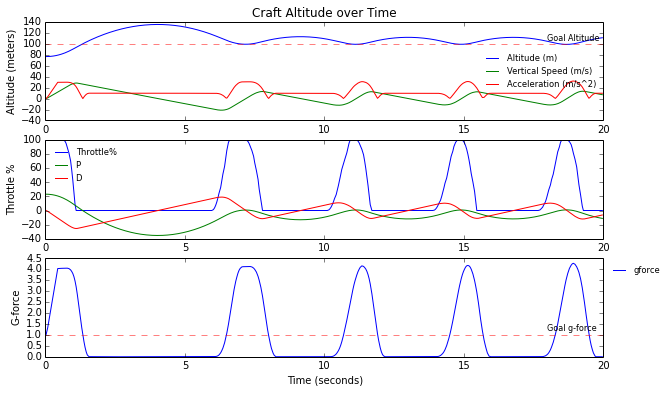

In [5]:
# To run in kOS console: RUN hover3(pos1.txt,20,0.05,0).
data = loadData('collected_data\\pos1.txt')
plotData(data)

Great! The controller burned us about 100m and then tried staying there, but there is quite a lot of bounce, maybe if we tweak our gains some. 

Let's try gains of $Kp = 0.08,\ \ Kd = 0.04$.

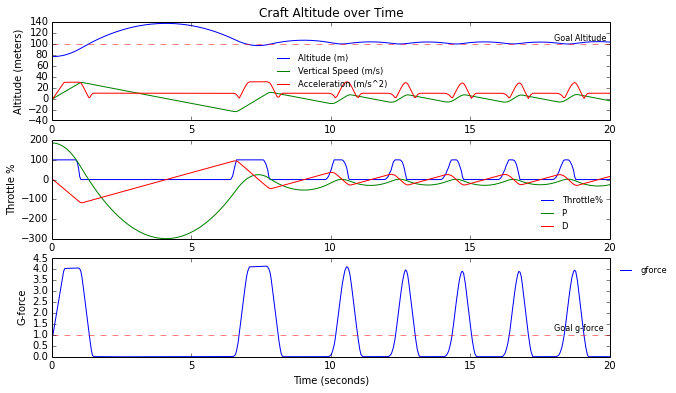

In [6]:
# To run in kOS console: RUN hover3(pos2.txt,20,0.08,0.04).
data = loadData('collected_data\\pos2.txt')
plotData(data)

Hmm, after trying a few other combinations, it seems like there's a conceptual error here keeping us from getting to a smooth point. 

We've been trying to build our controller with $thrott = thrott + \Delta thrott$$ which means it takes time to overcome our previous throttle, introducing this lag between our current position/velocity and goal one, that shows up as an oscillation.

The kOS script used is `hover3.ks` and these tests are run by calling `RUN hover3(posN.txt,20,Kp,Kd)`. For example for $Kp=0.08$ and $Kd=0.04$ the command is `RUN hover3(pos2.txt,20,0.08,0.04)`.

# Hover set-point
Instead let's figure out how to set our throttle point for hovering, and set $thrott = thrott_{hover} + \Delta thrott$

We know our ship's current max thrust with 100%, which we will call $Thrust_{available}$. What we want to find is our $Throttle_\%$ which would be 

$$Throttle_\% = \frac {Thrust_{desired}}{Thrust_{available}}$$

Where $Throttle_\%$ is between 0 and 1 (0 - 100%). Our $Thrust_{desired}$ is when we have a thrust to weight ratio of 1, matching gravitational acceleration.

$$
\begin{equation}
TWR = \frac{F}{mg} = 1\\
F_{thrust} = mg \\ 
g = \frac{\mu _{planet}}{(PLANET:RADIUS)^2} \\ 
Thrust_{desired} = SHIP:MASS * g \\
\end{equation}
$$

Finally that gives us

$$Throttle_\% = \frac {SHIP:MASS * \frac{\mu _{planet}}{(PLANET:RADIUS)^2}}{Thrust_{available}}$$

    LOCK hover_throttle_level TO MIN(1, MAX(0, SHIP:MASS * g / MAX(0.0001, curr_engine:AVAILABLETHRUST))).

Okay, moment of truth. Let's start small with $Kp = 0.01,\ \ Kd = 0.001$ and set  $altitude_{goal} = 100\ \text{meters}$. Shown with the solid red line across.

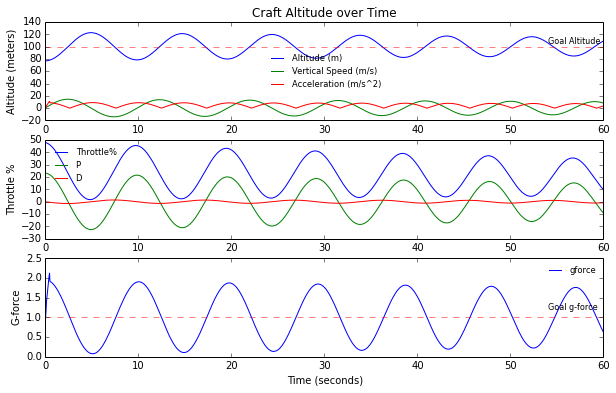

In [7]:
# To run in kOS console: RUN hover4(hover0.txt,60,0.01,0.001).
data = loadData('collected_data\\hover0.txt')
plotData(data)

It's stably oscillating! This is a good sign, showing our hover setpoint is doing it's job, the proportional gain is there, and there's barely any derivative gain.

Let's bump up the derivative gain to $Kd = 0.01$.

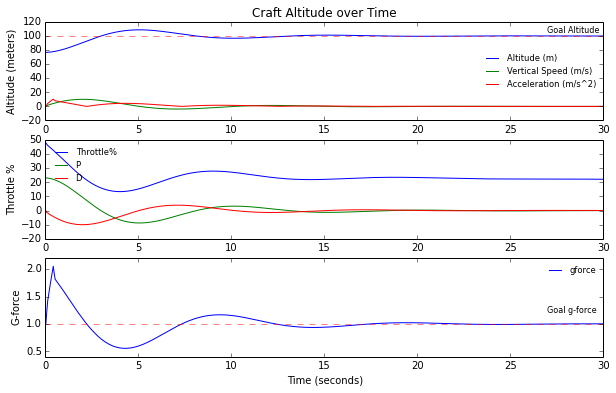

In [8]:
# To run in kOS console: RUN hover4(hover1.txt,60,0.01,0.01).
data = loadData('collected_data\\hover1.txt')
plotData(data)

Woohoo! It oveshoots a little but stablizes smoothly at 100m! Great to see this going in the game, looks a bit like the SpaceX grasshopper.

![Hovering at 100m](images/hover.png)

The kOS script used is `hover4.ks` and these tests are run by calling `RUN hover4(hoverN.txt,20,Kp,Kd)`.

# Tweaking gains

Now let's try and optimize the gains to reduce the rise time.

We take a quick shot by increasing both gains to $Kp = 0.1,\ \ Kd = 0.1$

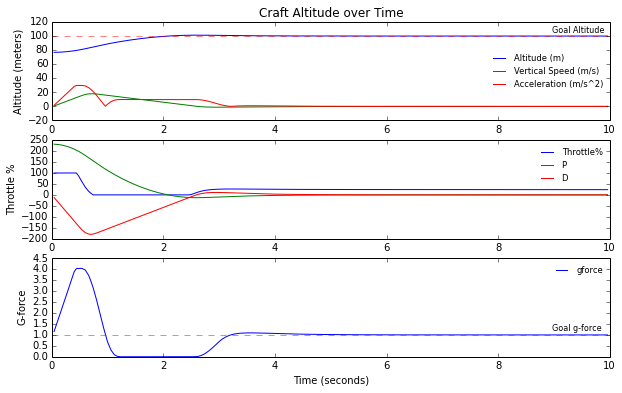

In [9]:
# To run in kOS console: RUN hover4(hover2.txt,10,0.1,0.1).
data = loadData('collected_data\\hover2.txt')
plotData(data)

Much faster! What happens if we change the altitude to say 300m?

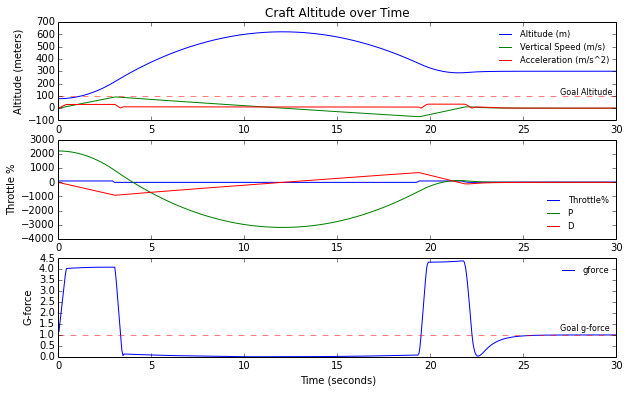

In [10]:
# To run in kOS console: RUN hover5(hover3.txt,10,0.1,0.1,300).
data = loadData('collected_data\\hover3.txt')
plotData(data)

Hmm some pretty big overshoot, but it does it! Next up is to apply some standardized techniques for finding gain values.

To be continued...